In [1]:
from haskellian import funcs as F, iter as I
import numpy as np
import cv2 as cv
import pure_cv as vc
import robust_extraction2 as re
import scoresheet_models as sm

models = sm.ModelsCache()
img = vc.imread('dieppe-perspective.jpg')
model = (await models.fetch('boutique-echecs')).unsafe()

[ WARN:0@0.437] global loadsave.cpp:241 findDecoder imread_('dieppe-perspective.jpg'): can't open/read file: check file path/integrity


error: OpenCV(4.10.0) /io/opencv/modules/imgproc/src/color.cpp:196: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'


In [2]:
model

NameError: name 'model' is not defined

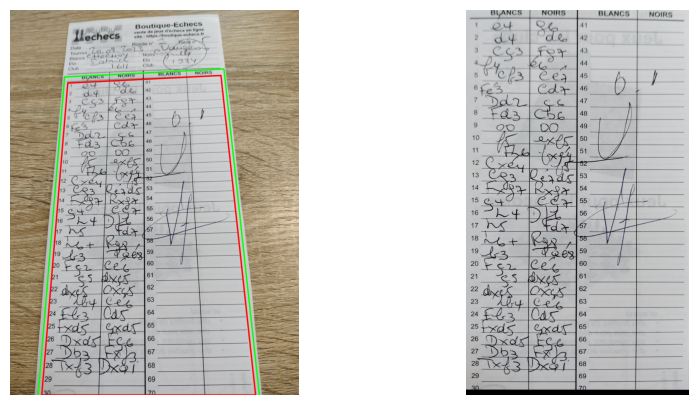

In [2]:
h0, w0 = img.shape[:2]
raw_corners = np.array([
  [0.2, 0.19],
  [0.73, 0.17],
  [0.85, 1],
  [0.11, 1]
]) * [w0, h0]
corners = vc.corners.pad(raw_corners, padx=0.04, pady=0.04)
corr = vc.corners.correct(img, corners)
h, w = corr.shape[:2]
draw = F.pipe(img, *[
  vc.draw.contours(contours=[raw_corners], thickness=15),
  vc.draw.contours(contours=[corners], color=(0, 255, 0), thickness=15)
])
vc.show(draw, corr)

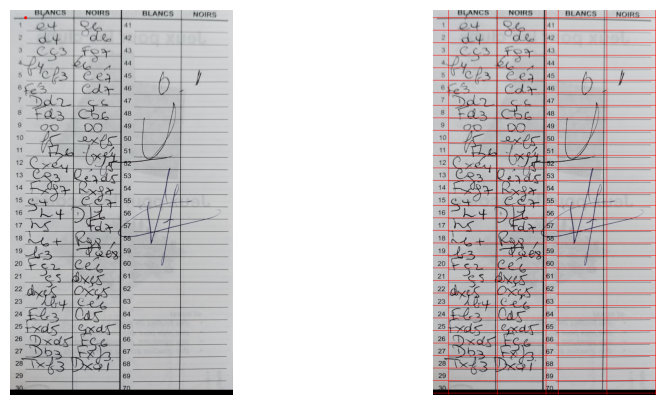

In [3]:
tl = np.array([0.07, 0.02]); size=np.array([0.91, 1.3])
coords = vc.Rect(tl=tl, size=size)
vs = np.array([tl, tl+size]) * [w, h]
vc.show(
  vc.draw.vertices(corr, vs, radius=15),
  sm.draw(corr, model, s=size, t=tl)
)

In [4]:
def unwarp_contours(contours: vc.Contours, corners: vc.Corners) -> vc.Contours:
  M, _ = vc.corners.homography(corners)
  Minv = np.linalg.inv(M)
  return vc.corners.warp(contours, Minv)

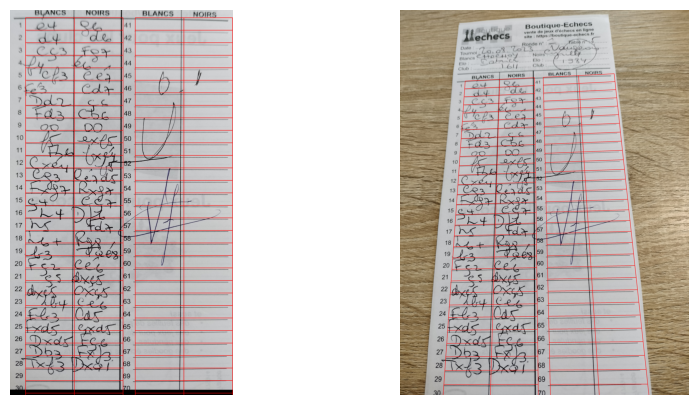

In [8]:
cnts = sm.contours(model, tl=tl, size=size) * [w, h]
cnts2 = unwarp_contours(cnts, corners)
vc.show(
  vc.draw.contours(corr, cnts),
  vc.draw.contours(img, cnts2),
)

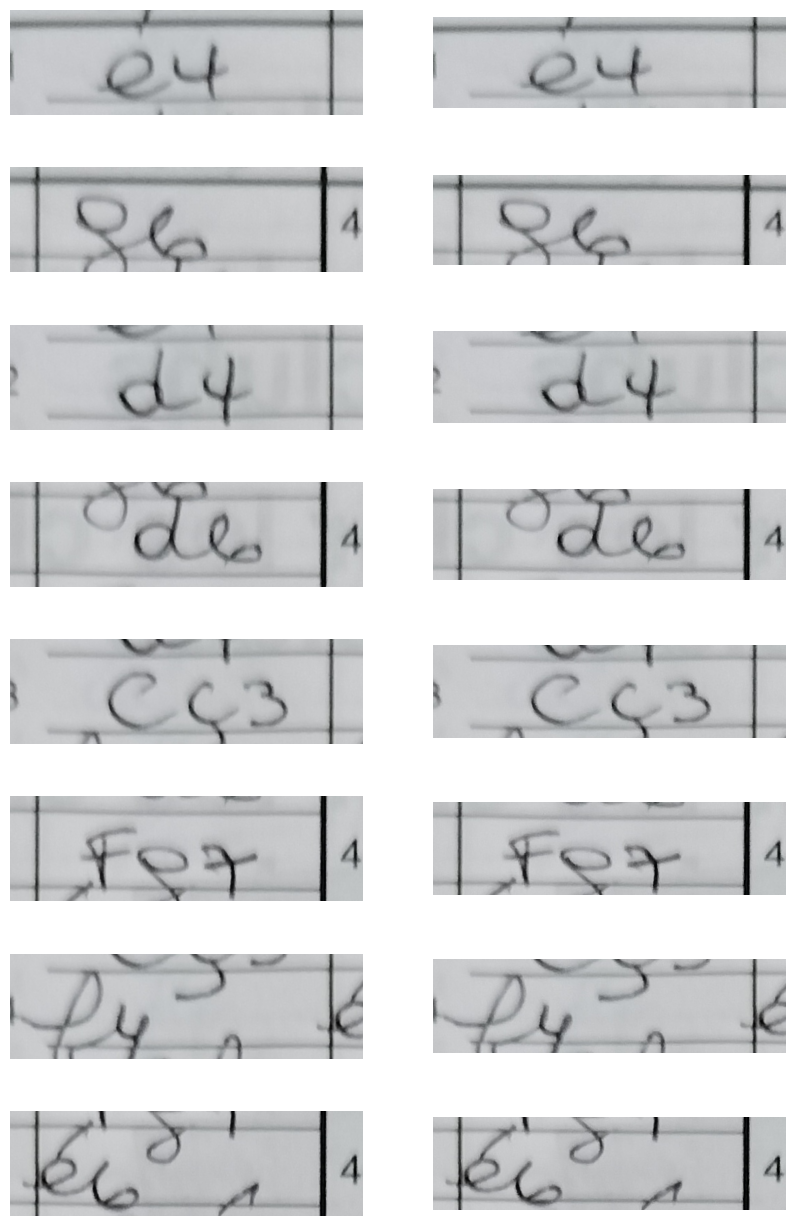

In [6]:
boxes1 = vc.extract_contours(corr, cnts)
boxes2 = vc.extract_contours(img, cnts2)
boxes = I.flatten(zip(boxes1, boxes2)).take(16).sync()
vc.show(*boxes, ncols=2, height=2)
# h1, w1 = boxes1[0].shape[:2]
# h2, w2 = boxes2[0].shape[:2]